## Task 15 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

Desiree Miraldo  

* Task (for Lecture 15):

Write a Python Class to implement the muscle model developed during the course.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from Muscle import Muscle

%matplotlib notebook

### Subject's anthropometrics

From Thelen(2003) - dorsiflexors:

Using BSP values from Dempster's model adapted by Winter (2009), available in [BodySegmentParameters.ipynb](https://github.com/BMClab/bmc/blob/master/notebooks/BodySegmentParameters.ipynb)

In [2]:
m = 75 #kg
g = 9.81 #(m/s^2)
Lfoot = 26e-2 #(m)
mfoot = 0.0145*m #0.0145 from column Mass (kg)
Rcm = 0.5* Lfoot #0.5 from column CM prox (m)
Ifoot = mfoot*(.69*Lfoot)**2 #0.690 from column Rg prox (kg*m^2)


### Initial conditions

In [3]:
phiTA = 0 #start as 0 degree flexion (rad)
phidTA = 0 #zero velocity

phiSOL = 0 #start as 0 degree flexion (rad)
phidSOL = 0 #zero velocity

t0 = 0 #Initial time
tf = .5 #Final Time
h = 1e-4 #integration step size and step counter

In [4]:
t = np.arange(t0,tf,h)
F = np.empty([2,t.shape[-1]])
Fkpe = np.empty([2,t.shape[-1]])
FiberLen = np.empty([2,t.shape[-1]])
TendonLen = np.empty([2,t.shape[-1]])
a_dynamics = np.empty([2,t.shape[-1]])
phi_dynamics = np.empty([2,t.shape[-1]])
fiberVelocity = np.empty([2,t.shape[-1]])
moment     = np.empty([2,t.shape[-1]])

#### Activation dynamics parameters

In [5]:
# defining u (Initial conditional for Brain's activation)
form = 'step'

def createinput_u(form,t,h=.01,plot=True):
    if (form == 'sinusoid'):
        u = .2*np.sin(np.pi*t) +.7
    elif (form == 'step'):
        u = np.ones[2,t.shape[-1]]*h
        u[:int(1/h)] = 0
        u[int(1/h):int(3/h)] = 1

    elif (form == 'pulse'):
        u = np.ones[2,t.shape[-1]]*h
        u[int(1/h):int(3/h)] = 1

    if plot:
        plt.figure()
        plt.plot(u)
        plt.title('u wave form')
    return u   

#u = createinput_u(form,h)
u = np.ones(t.shape[-1])/1

#### Coeficients from Elias(2014)

In [6]:
#parameters from Elias(2014) (meter/deg^ind)
A_TA = np.array([30.60,-7.44e-2,-1.41e-4,2.42e-6,1.50e-8])*1e-2 
B_TA = np.array([4.30,1.66e-2,-3.89e-4,-4.45e-6,-4.34e-8])*1e-2
A_SO = np.array([32.30, 7.22e-2, -2.24e-4, -3.15e-6, 9.27e-9])*1e-2
B_SO = np.array([-4.10, 2.57e-2, 5.45e-4, -2.22e-6, -5.50e-9])*1e-2
A_MG = np.array([46.40, 7.48e-2, -1.13e-4, -3.50e-6, 7.35e-9])*1e-2
A_MG = np.array([24.30, 1.30e-2, 6.08e-4, -1.87e-6, -1.02e-8])*1e-2
A_LG = np.array([45.50, 7.62e-2, -1.25e-4, -3.55e-6, 7.65e-9])*1e-2 
B_LG = np.array([24.40, 1.44e-2, 6.18e-4, -1.94e-6, -1.02e-8])*1e-2 

In [7]:
# Using muscle specific parameters from Thelen(2003) - Table 2

FmaxSOL =3150+3150+1750 #sum of plantarflexor Fmax

dorsiflexor = Muscle(Lce_o=.09, Lslack=2.4, alpha=7*np.pi/180, Fmax=1400, dt=h)
soleus = Muscle(Lce_o=.03, Lslack=8.8, alpha=25*np.pi/180, Fmax=FmaxSOL, dt=h)
#gastroc = Muscle(Lce_o=.05, Lslack=8.3, alpha=14*np.pi/180, Fmax=1750, dt=h)
#plantarflexor = Muscle(Lce_o=.031, Lslack=10, alpha=12*np.pi/180, Fmax=3150, dt=h)

In [8]:
#Dorsiflexor

#dorsiflexor.Lnorm_ce = .087/dorsiflexor.Lce_o #norm
dorsiflexor.Lnorm_ce = (.306-(dorsiflexor.Lslack)/np.cos(dorsiflexor.alpha))/dorsiflexor.Lce_o


## Functions

In [9]:
def totalMuscleLength(phi,A):
    '''
    Compute length Muscle+tendon - Eq. 8 from Elias(2014)
    
    Inputs:
        A = parameters from Elias(2014) (meter/deg^ind)
        thetaAnkle = angle of ankle
    Output:
        Lm = length Muscle+tendon
    
    '''
    phi = phi*180/np.pi
    
    Lm = 0
    for i in range(len(A)):
        Lm += A[i]*(phi**i)
    
    return Lm   
    

In [10]:
def momentArm(phi,B):
    '''
    Compute moment arm of muscle - Eq. 9 from Elias(2014)
    
    Inputs:
        A = parameters from Elias(2014) (meter/deg^ind)
        B = parameters from Elias(2014) (meter/deg^ind)
    Output:
        Lm = length Muscle+tendon
    '''
    
    phi = phi*180/np.pi
    
    Rf = 0
    for i in range(len(B)):
        Rf += B[i]*(phi**i) #Eq. 9 from Elias(2014)
    
    return Rf   
    

In [11]:
def momentJoint(Rf,Fnorm_tendon,Fmax,m,g,phi):
    '''
    Inputs:
        Rf = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
        phi = angle (deg)
    Output:
        M = Total moment with respect to joint
    '''
    M=Rf*Fnorm_tendon*Fmax - m*g*Rcm*np.sin(np.pi/2-phi)
    return M

In [12]:
def angularAcelerationJoint(M,I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

### Check initial conditions

## Simulation - Parallel

In [17]:
#Normalizing
for i in range(len(t)):
    
    LmTA =  totalMuscleLength(phiTA,A_TA)
    LmSOL =  totalMuscleLength(phiSOL,A_SO)
    
    
    dorsiflexor.updateMuscle(Lm=LmTA, u=u[i])
    soleus.updateMuscle(Lm=LmSOL, u=u[i])
  
    
    #Compute MomentJoint
    RfTA = momentArm(phiTA,B_TA) #moment arm
    RfSOL = momentArm(phiSOL,B_SO) #moment arm
    
    MTA = momentJoint(RfTA,dorsiflexor.Fnorm_tendon,dorsiflexor.Fmax,mfoot,g,phiTA)
    MSOL = momentJoint(RfSOL,soleus.Fnorm_tendon,soleus.Fmax,mfoot,g,phiSOL)
    
    #Compute Angular Aceleration Joint
    phiddTA = angularAcelerationJoint(MTA,Ifoot)
    
    #Euler integration steps 
    phidTA = phidTA + h*phiddTA
    phiTA  = phiTA  +h*phidTA

    # Store variables in vectors
    F[0,i] = dorsiflexor.Fnorm_tendon*dorsiflexor.Fmax
    Fkpe[0,i] = dorsiflexor.Fnorm_kpe*dorsiflexor.Fmax
    FiberLen[0,i] = dorsiflexor.Lnorm_ce*dorsiflexor.Lce_o
    TendonLen[0,i] = dorsiflexor.Lnorm_see*dorsiflexor.Lce_o
    a_dynamics[0,i] = dorsiflexor.a
    fiberVelocity[0,i] = dorsiflexor.Lnorm_cedot*dorsiflexor.Lce_o
    phi_dynamics[0,i] = phiTA
    moment[0,i] = MTA

## Plots 

<IPython.core.display.Javascript object>


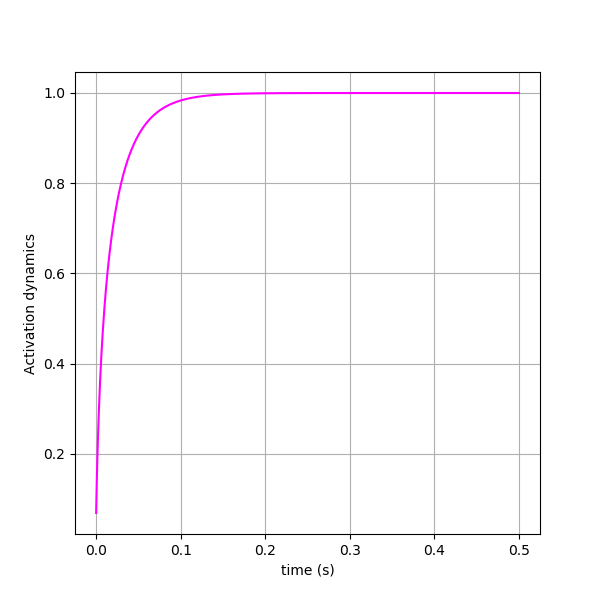

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,a_dynamics[0,:],c='magenta')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics');

<IPython.core.display.Javascript object>


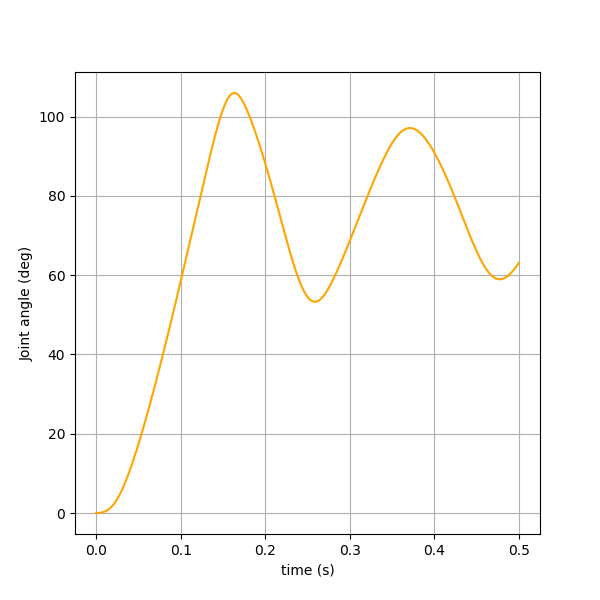

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,phi_dynamics[0,:]*180/np.pi ,c='orange')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Joint angle (deg)');

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)');

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,moment,c='green')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Moment joint');

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,fiberVelocity,c='purple')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('fiber Velocity (m/s)');

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.12, hspace=None,left=None, bottom=None, right=None, top=None,)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)');
#ax[i].legend(loc='best')